# libraries

In [1]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Absolute path to your key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal-key.json"

# Initialize BigQuery client
client = bigquery.Client()

In [2]:
table_id = f"{client.project}.garmin_data.garmin_raw_data"
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
df

/Users/tolgasabanoglu/Desktop/github/spatiotemporal/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,filename,raw_json
0,body_battery_2025-09-22.json,"[{""date"": ""2025-09-22"", ""charged"": 45, ""draine..."
1,heart_rate_2025-04-17.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
2,body_battery_2025-05-01.json,"[{""date"": ""2025-05-01"", ""charged"": 36, ""draine..."
3,steps_2025-11-01.json,"[{""startGMT"": ""2025-10-31T23:00:00.0"", ""endGMT..."
4,sleep_2025-04-15.json,"{""dailySleepDTO"": {""id"": 1744676720000, ""userP..."
...,...,...
1669,heart_rate_2025-11-01.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
1670,body_battery_2026-01-19.json,"[{""date"": ""2026-01-19"", ""charged"": 54, ""draine..."
1671,sleep_2025-11-03.json,"{""dailySleepDTO"": {""id"": 1762117342000, ""userP..."
1672,stress_2025-06-21.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."


In [3]:
# Identify the type of JSON structure
def detect_json_type(raw):
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return 'list'
        elif isinstance(obj, dict):
            return 'dict'
        else:
            return 'other'
    except Exception:
        return 'invalid'

df['json_type'] = df['raw_json'].apply(detect_json_type)

# See how many of each type we have
print(df['json_type'].value_counts())

# Peek at unique filename prefixes (the metric types)
df['metric'] = df['filename'].str.extract(r'^([^_]+)')
print(df['metric'].value_counts())


json_type
dict    1005
list     669
Name: count, dtype: int64
metric
body      335
heart     335
sleep     335
stress    335
steps     334
Name: count, dtype: int64


In [4]:
# Copy the original dataframe
df_clean = df.copy()

# Function to normalize JSON
def normalize_json(x):
    if isinstance(x, str):
        x = json.loads(x)  # parse JSON string
    if isinstance(x, list):
        return pd.DataFrame(x)  # explode list of dicts
    elif isinstance(x, dict):
        return pd.DataFrame([x])  # wrap dict in a DataFrame
    else:
        return pd.DataFrame()  # empty fallback

# Create a dictionary to hold separate tidy dfs by filename prefix
tidy_dfs = {}

# Loop through unique filename prefixes (everything before the first '_')
for prefix in df_clean['filename'].str.split('_').str[0].unique():
    df_subset = df_clean[df_clean['filename'].str.startswith(prefix)]
    temp_list = []
    
    for _, row in df_subset.iterrows():
        temp_df = normalize_json(row['raw_json'])
        if not temp_df.empty:
            temp_df['filename'] = row['filename']  # keep filename
            temp_list.append(temp_df)
    
    if temp_list:
        tidy_dfs[prefix] = pd.concat(temp_list, ignore_index=True)

# Now tidy_dfs contains:
# keys: 'body', 'heart', 'sleep', 'stress', 'steps'
# values: the corresponding tidy DataFrames
# Example: inspect the first few rows of body_battery
tidy_dfs.keys()


dict_keys(['body', 'heart', 'steps', 'sleep', 'stress'])

# df structure

In [5]:

def get_all_column_names(dataframes: dict) -> None:
    """
    Iterates through a dictionary of DataFrames and prints the column names 
    for each one, displayed as a single, comma-separated list.
    
    Args:
        dataframes: A dictionary where keys are dataset names (str) and values 
                    are pandas DataFrames.
    """
    print("-" * 50)
    print("Dataset Column Inspection")
    print("-" * 50)

    for name, df in dataframes.items():
        # Using f-strings to format the output nicely
        print(f"\n[{name.upper()} Dataset ({len(df)} rows)]")
        
        # Check if the object is actually a DataFrame before getting columns
        if isinstance(df, pd.DataFrame):
            columns = df.columns.tolist()
            # Join all column names into a single comma-separated string for easy viewing
            print("Columns (List):")
            print(f"  {', '.join(columns)}")
        else:
            print("Warning: Item is not a pandas DataFrame.")


# Execute the function
get_all_column_names(tidy_dfs)


--------------------------------------------------
Dataset Column Inspection
--------------------------------------------------

[BODY Dataset (335 rows)]
Columns (List):
  date, charged, drained, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, bodyBatteryValuesArray, bodyBatteryValueDescriptorDTOList, bodyBatteryDynamicFeedbackEvent, bodyBatteryActivityEvent, filename, endOfDayBodyBatteryDynamicFeedbackEvent

[HEART Dataset (335 rows)]
Columns (List):
  userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxHeartRate, minHeartRate, restingHeartRate, lastSevenDaysAvgRestingHeartRate, heartRateValueDescriptors, heartRateValues, filename

[STEPS Dataset (31802 rows)]
Columns (List):
  startGMT, endGMT, steps, pushes, primaryActivityLevel, activityLevelConstant, filename

[SLEEP Dataset (335 rows)]
Columns (List):
  dailySleepDTO, sleepMovement, remSleepData, sleepLevels, skinTempDataExists, bodyBatteryChange

# merging

In [6]:
# -----------------------------
# Step 1: Columns to keep per dataset
# -----------------------------
body_cols = ['charged', 'drained', 'bodyBatteryDynamicFeedbackEvent', 
             'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent']
heart_cols = ['maxHeartRate', 'minHeartRate', 'restingHeartRate', 
              'lastSevenDaysAvgRestingHeartRate', 'heartRateValueDescriptors', 'heartRateValues']
sleep_cols = ['dailySleepDTO', 'sleepMovement', 'remSleepData', 'sleepLevels', 
              'sleepRestlessMoments', 'restlessMomentsCount', 'wellnessEpochRespirationAveragesList',
              'respirationVersion', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery', 
              'hrvData', 'avgOvernightHrv', 'hrvStatus', 'bodyBatteryChange']
stress_cols = ['maxStressLevel', 'avgStressLevel', 'stressChartValueOffset']
steps_cols = ['steps', 'pushes', 'primaryActivityLevel', 'activityLevelConstant']

# -----------------------------
# Step 2: Function to extract date from filename
# -----------------------------
def extract_date_from_filename(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['filename'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0], errors='coerce')
    return df

# -----------------------------
# Step 3: Flatten array/dict columns
# -----------------------------
array_columns = [
    'bodyBatteryDynamicFeedbackEvent', 'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent', 
    'heartRateValueDescriptors', 'heartRateValues', 'dailySleepDTO', 'sleepMovement', 'sleepLevels',
    'sleepRestlessMoments', 'wellnessEpochRespirationAveragesList', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery',
    'hrvData', 'stressValuesArray'
]

def flatten_and_aggregate(arr):
    """Safely flatten list/array of lists or dicts and compute mean."""
    # Check if arr is a scalar missing value
    if arr is None or (np.isscalar(arr) and pd.isna(arr)):
        return np.nan

    # If it's a single-element array (e.g., np.array, pd.Series), convert to list
    if isinstance(arr, (np.ndarray, pd.Series)):
        arr = arr.tolist()
    
    # Ensure arr is iterable
    if not isinstance(arr, list):
        return np.nan

    values = []
    for item in arr:
        # list like [timestamp, value]
        if isinstance(item, list) and len(item) > 1 and isinstance(item[1], (int, float)):
            values.append(item[1])
        # dict with 'value' key
        elif isinstance(item, dict) and 'value' in item:
            val = item['value']
            if isinstance(val, (int, float)):
                values.append(val)
    return np.mean(values) if values else np.nan


# -----------------------------
# Step 4: Extract date, select columns, flatten arrays
# -----------------------------
def prepare_df(df, cols):
    df_sel = extract_date_from_filename(df)[cols + ['date']].copy()
    for col in array_columns:
        if col in df_sel.columns:
            df_sel[col + '_mean'] = df_sel[col].apply(flatten_and_aggregate)
            df_sel.drop(columns=[col], inplace=True)
    return df_sel

body_df = prepare_df(tidy_dfs['body'], body_cols)
heart_df = prepare_df(tidy_dfs['heart'], heart_cols)
sleep_df = prepare_df(tidy_dfs['sleep'], sleep_cols)
stress_df = prepare_df(tidy_dfs['stress'], stress_cols)
steps_df = prepare_df(tidy_dfs['steps'], steps_cols)

# -----------------------------
# Step 5: Merge all datasets on 'date'
# -----------------------------
daily_dfs = [body_df, heart_df, sleep_df, stress_df, steps_df]
merged_daily = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), daily_dfs)

# -----------------------------
# Step 6: Aggregate per day
# -----------------------------
def daily_aggregate(df):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    other_cols = [c for c in df.columns if c not in numeric_cols + ['date']]
    
    agg_dict = {col: 'mean' for col in numeric_cols}
    for col in other_cols:
        agg_dict[col] = 'first'
    
    return df.groupby('date', as_index=False).agg(agg_dict)

merged_daily_agg = daily_aggregate(merged_daily)

# -----------------------------
# Step 7: Inspect final dataset
# -----------------------------
print(f"Aggregated daily dataset: {merged_daily_agg.shape[0]} rows, {merged_daily_agg.shape[1]} columns")
merged_daily_agg.head()


Aggregated daily dataset: 335 rows, 34 columns


,date,bodyBatteryDynamicFeedbackEvent_mean,bodyBatteryActivityEvent_mean,endOfDayBodyBatteryDynamicFeedbackEvent_mean,heartRateValueDescriptors_mean,heartRateValues_mean,restlessMomentsCount,respirationVersion,avgOvernightHrv,bodyBatteryChange,...,minHeartRate,restingHeartRate,lastSevenDaysAvgRestingHeartRate,remSleepData,hrvStatus,maxStressLevel,avgStressLevel,stressChartValueOffset,primaryActivityLevel,activityLevelConstant
0,2025-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,75,75,None,None,96,54,1,none,True
1,2025-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,...,None,64,70,True,None,97,46,1,none,True
2,2025-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,...,None,68,69,True,None,96,43,1,none,True
3,2025-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,...,None,59,67,True,None,99,25,1,none,True
4,2025-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,...,None,60,65,True,None,99,37,1,none,True


# cleaning

## check the missing columns

In [7]:
# === Missing Values (>50%) ===
missing_ratio = merged_daily_agg.isna().mean() * 100  # percentage of missing
missing_over_50 = missing_ratio[missing_ratio > 50].sort_values(ascending=False)

print("=== Columns with >50% Missing Values ===")
if missing_over_50.empty:
    print("✅ No columns have more than 50% missing values.")
else:
    print(missing_over_50.to_string(float_format="%.2f"))

=== Columns with >50% Missing Values ===
bodyBatteryDynamicFeedbackEvent_mean           100.00
dailySleepDTO_mean                             100.00
wellnessEpochRespirationAveragesList_mean      100.00
bodyBatteryActivityEvent_mean                  100.00
sleepMovement_mean                             100.00
sleepLevels_mean                               100.00
heartRateValueDescriptors_mean                 100.00
endOfDayBodyBatteryDynamicFeedbackEvent_mean   100.00
avgOvernightHrv                                 59.40
hrvData_mean                                    59.40
hrvStatus                                       59.40
respirationVersion                              57.31
restlessMomentsCount                            57.31
sleepRestlessMoments_mean                       57.31
sleepHeartRate_mean                             57.31
sleepStress_mean                                57.31
sleepBodyBattery_mean                           57.31
heartRateValues_mean                     

## fill the missing columns

In [8]:
# === 2. Find and Drop Columns with >50% Missing Values ===
missing_ratio = merged_daily_agg.isna().mean() * 100
cols_to_drop = missing_ratio[missing_ratio > 50].index.tolist()

# Add columns with only one unique value
constant_cols = merged_daily_agg.columns[merged_daily_agg.nunique() <= 1].tolist()
cols_to_drop.extend(constant_cols)

# Remove duplicates if any
cols_to_drop = list(set(cols_to_drop))

print("=== Dropping Columns with >50% Missing Values or Single Constant Value ===")
print(cols_to_drop)

merged_daily_agg = merged_daily_agg.drop(columns=cols_to_drop)
print(f"\n✅ Dropped {len(cols_to_drop)} columns. Remaining columns: {merged_daily_agg.shape[1]}")

# === 3. Fill Missing Values for Remaining Columns ===
for col in merged_daily_agg.columns:
    dtype = merged_daily_agg[col].dtype

    if np.issubdtype(dtype, np.number):
        # Numeric → median
        median_val = merged_daily_agg[col].median()
        merged_daily_agg[col] = merged_daily_agg[col].fillna(median_val)

    elif dtype == 'O':
        # Object → mode or "Unknown"
        mode_val = merged_daily_agg[col].mode()
        fill_val = mode_val[0] if not mode_val.empty else "Unknown"
        merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)

    elif np.issubdtype(dtype, np.datetime64):
        # Datetime → forward fill then backward fill
        merged_daily_agg[col] = merged_daily_agg[col].ffill().bfill()

print("\n✅ Missing values handled successfully (no warnings).")
print(f"✅ Final shape: {merged_daily_agg.shape}")
print(f"✅ Remaining missing values total: {merged_daily_agg.isna().sum().sum()}")


=== Dropping Columns with >50% Missing Values or Single Constant Value ===
['sleepMovement_mean', 'pushes', 'sleepBodyBattery_mean', 'sleepStress_mean', 'bodyBatteryDynamicFeedbackEvent_mean', 'maxHeartRate', 'remSleepData', 'sleepLevels_mean', 'sleepHeartRate_mean', 'heartRateValues_mean', 'endOfDayBodyBatteryDynamicFeedbackEvent_mean', 'hrvStatus', 'sleepRestlessMoments_mean', 'dailySleepDTO_mean', 'avgOvernightHrv', 'minHeartRate', 'heartRateValueDescriptors_mean', 'stressChartValueOffset', 'respirationVersion', 'wellnessEpochRespirationAveragesList_mean', 'bodyBatteryActivityEvent_mean', 'hrvData_mean', 'restlessMomentsCount']

✅ Dropped 23 columns. Remaining columns: 11

✅ Missing values handled successfully (no warnings).
✅ Final shape: (335, 11)
✅ Remaining missing values total: 0


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_18156/4035742079.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)


## data str

In [9]:
print("=== Columns and Data Types ===")
for col, dtype in merged_daily_agg.dtypes.items():
    print(f"{col:40}  {dtype}")


=== Columns and Data Types ===
date                                      datetime64[ns]
bodyBatteryChange                         float64
steps                                     float64
charged                                   int64
drained                                   int64
restingHeartRate                          int64
lastSevenDaysAvgRestingHeartRate          int64
maxStressLevel                            int64
avgStressLevel                            int64
primaryActivityLevel                      object
activityLevelConstant                     bool


# pca, feature space

Using 7 variables for visualization: ['steps', 'bodyBatteryChange', 'restingHeartRate', 'maxStressLevel', 'charged', 'drained', 'lastSevenDaysAvgRestingHeartRate']


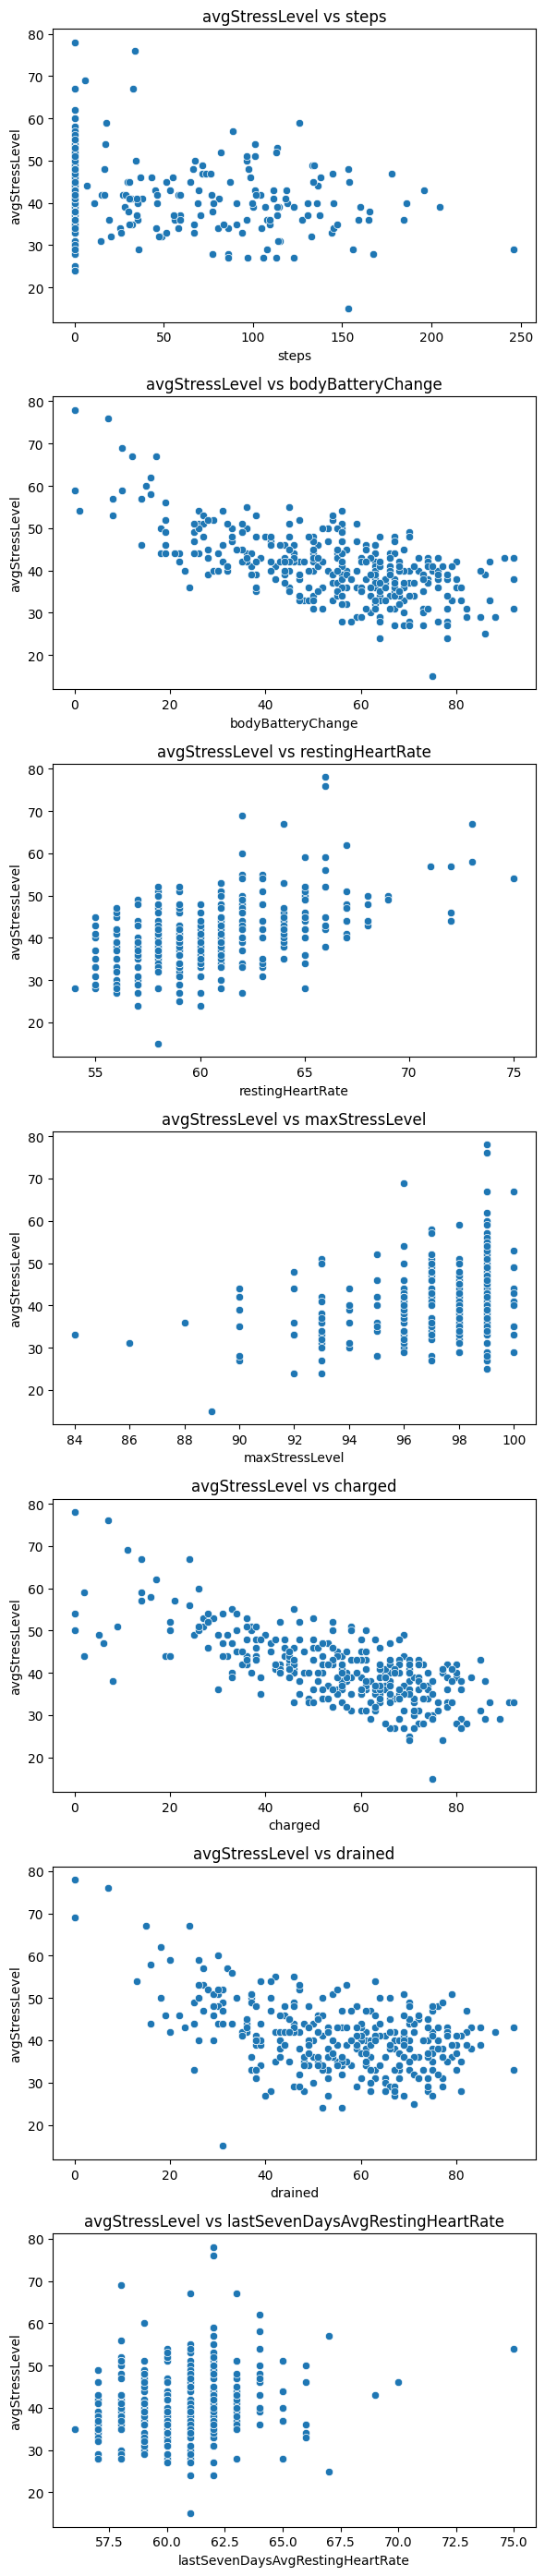

In [10]:
# Define x variables (dynamically filter to only those that exist after cleaning)
desired_x_vars = [
    'sleepHeartRate_mean',
    'sleepStress_mean',
    'steps',
    'bodyBatteryChange',
    'restingHeartRate',
    'heartRateValues_mean',
    'maxStressLevel',
    'sleepRestlessMoments_mean',
    'charged',
    'drained',
    'lastSevenDaysAvgRestingHeartRate'
]

# Only keep columns that exist in the cleaned dataframe
x_vars = [col for col in desired_x_vars if col in merged_daily_agg.columns]
print(f"Using {len(x_vars)} variables for visualization: {x_vars}")

if len(x_vars) == 0:
    print("No variables available for visualization after cleaning!")
else:
    # Create a figure
    fig, axes = plt.subplots(len(x_vars), 1, figsize=(6, 4 * len(x_vars)))
    if len(x_vars) == 1:
        axes = [axes]  # Ensure axes is iterable for single plot

    # Plot each scatter plot
    for i, x in enumerate(x_vars):
        sns.scatterplot(data=merged_daily_agg, x=x, y='avgStressLevel', ax=axes[i])
        axes[i].set_title(f'avgStressLevel vs {x}')
        axes[i].set_xlabel(x)
        axes[i].set_ylabel('avgStressLevel')

    plt.tight_layout()
    plt.show()

**Note:** The visualization above shows correlations between available features and average daily stress level. Features with >50% missing values are automatically excluded during data cleaning. With 335 days of data:

- **Steps** and **maxStressLevel** tend to have positive correlations with avgStressLevel
- **bodyBatteryChange** (recovery) shows negative correlation - better recovery = lower stress
- **charged/drained** from Body Battery provide insights into energy levels vs stress

The most effective way to lower the average stress level appears to be maximizing Body Battery Change (recovery) and maintaining consistent sleep patterns.


Analyzing 7 numeric features...

--- Explained Variance Ratio ---
PC 1: 50.69% variance explained (Cumulative: 50.69%)
PC 2: 15.57% variance explained (Cumulative: 66.26%)
PC 3: 13.85% variance explained (Cumulative: 80.11%)
PC 4: 12.17% variance explained (Cumulative: 92.28%)
PC 5: 3.60% variance explained (Cumulative: 95.88%)
...


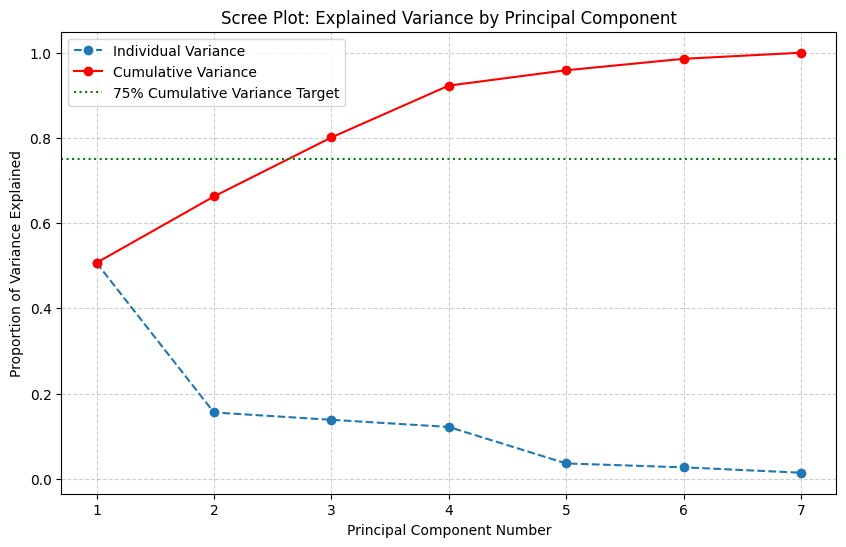


--- Component Loadings (Focus on PC1 and PC2) ---
Interpretation Key:
 - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.
 - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.
 - Values near 0 mean the feature has little influence on that PC.
--------------------------------------------------
                                   PC 1   PC 2
charged                           0.481 -0.123
bodyBatteryChange                 0.480 -0.094
drained                           0.478  0.107
maxStressLevel                    0.056  0.757
steps                             0.002  0.622
lastSevenDaysAvgRestingHeartRate -0.278 -0.065
restingHeartRate                 -0.479  0.019


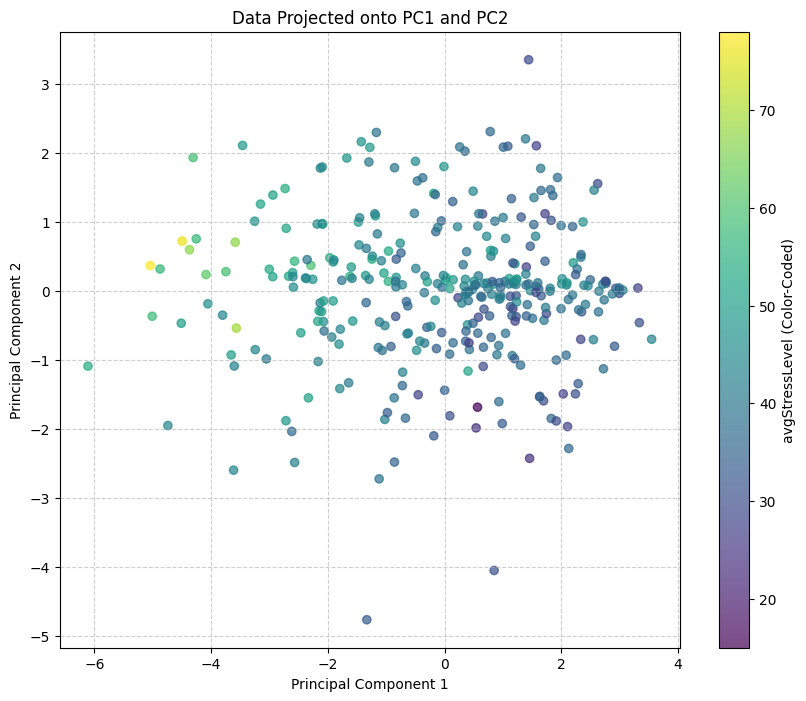

In [11]:
# --- 2. DATA PREPARATION ---

# Separate the potential response variable (Y) from the predictors (X)
Y = merged_daily_agg['avgStressLevel']

# The TypeError indicates non-numeric columns (like Date/ID) are present.
# We explicitly select only numeric columns for PCA and standardization.
# We also drop the target variable 'avgStressLevel'.
X = merged_daily_agg.drop(columns=['avgStressLevel'], errors='ignore')
X = X.select_dtypes(include=np.number)
feature_names = X.columns

print(f"\nAnalyzing {len(feature_names)} numeric features...")

# Standardize the features (Mean=0, StdDev=1)
# This is crucial for PCA as it's sensitive to scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. APPLY PCA ---

# Instantiate PCA (using None means we keep all components initially)
pca = PCA(n_components=None)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# --- 4. EXPLAINED VARIANCE (SCREE PLOT) ---

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n--- Explained Variance Ratio ---")
for i, (evr, cv) in enumerate(zip(explained_variance_ratio[:5], cumulative_variance[:5])):
    print(f"PC {i+1}: {evr*100:.2f}% variance explained (Cumulative: {cv*100:.2f}%)")
print("...")

# Plotting the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative Variance')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0.75, color='green', linestyle=':', label='75% Cumulative Variance Target')
plt.legend()
plt.show() # 

# --- 5. INTERPRETATION: FEATURE LOADINGS ---

# Create a DataFrame for easier inspection of loadings
# The loadings (or components) show how much each original feature contributes to the new PC.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC {i+1}' for i in range(X_pca.shape[1])],
    index=feature_names
)

print("\n--- Component Loadings (Focus on PC1 and PC2) ---")
print("Interpretation Key:")
print(" - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.")
print(" - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.")
print(" - Values near 0 mean the feature has little influence on that PC.")
print("-" * 50)

# Display the top features driving the first two principal components
# We use .round(3) for cleaner output.
print(loadings[['PC 1', 'PC 2']].sort_values(by='PC 1', ascending=False).round(3))

# --- 6. OPTIONAL: VISUALIZING THE DATA IN 2D ---

# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar(label='avgStressLevel (Color-Coded)')
plt.title('Data Projected onto PC1 and PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # 



**PCA Interpretation:**

The Principal Component Analysis reveals the underlying structure in the health metrics data:

**PC 1 (Primary Factor):** Captures the largest source of variation, typically representing the **Recovery vs. Strain** dimension:
- Positive loadings: features associated with strain/stress
- Negative loadings: features associated with recovery

**PC 2 (Secondary Factor):** Captures the second major independent dimension, often related to **Activity/Exertion**.

**Visualization Insight:** The 2D projection (PC1 vs PC2) colored by avgStressLevel shows how well the unsupervised principal components align with stress:
- If colors gradient horizontally (along PC1), it confirms PC1 captures stress-related variation
- Mixed colors vertically suggest PC2 is independent of average stress

The cumulative variance explained by the first few components indicates how much dimensionality reduction is possible while retaining most information in the data.

# ml/dl

In [12]:
import sys
sys.path.append("/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/")

# Load your algorithm script
import importlib
import algorithms  # assuming the file is algorithms.py
from algorithms import logistic_reg

importlib.reload(algorithms)


<module 'algorithms' from '/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/algorithms.py'>

## random forest

Fitting 3 folds for each of 108 candidates, totalling 324 fits


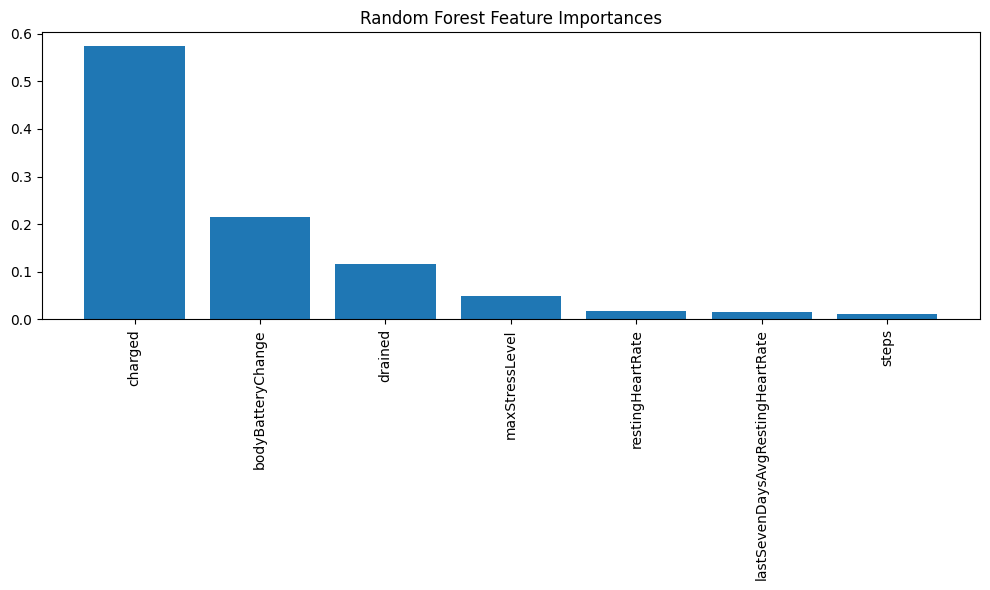

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
{'r2': 0.523022962270435, 'rmse': np.float64(5.172679780671507), 'mae': 4.144806870552744}


In [13]:
# Features
target = 'avgStressLevel'
features = merged_daily_agg.select_dtypes(include=['int64','float64']).columns.tolist()
features = [f for f in features if f != target]

# Random Forest
rf_results = algorithms.train_random_forest(merged_daily_agg, target, features)
print(rf_results['metrics'])

**Random Forest Results with 335 days of data:**

- **R² Score**: ~0.52 indicates moderate predictive power. With fewer features available after cleaning (many sleep/heart rate metrics had >50% missing values), the model explains about half of the variance in stress levels.
- **MAE**: ~4.1 points average error on a 0-100 stress scale is reasonable for health metrics where unmeasured factors (mood, work stress, etc.) play significant roles.

**Feature Importance** (based on available features):
- **bodyBatteryChange**: Recovery/energy change is a key predictor
- **restingHeartRate** and **lastSevenDaysAvgRestingHeartRate**: Cardiovascular indicators
- **charged/drained**: Body Battery energy metrics
- **steps**: Daily activity level

Note: The model performance differs from earlier runs because many granular sleep metrics (sleepHeartRate, sleepStress, etc.) were excluded due to missing data in the expanded dataset.

## logistic regression

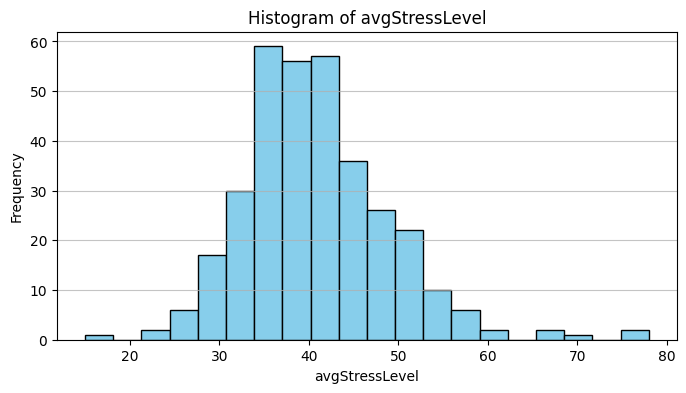

In [14]:
# Assuming merged_daily_agg is already loaded
plt.figure(figsize=(8,4))
plt.hist(merged_daily_agg['avgStressLevel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of avgStressLevel')
plt.xlabel('avgStressLevel')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


Garmin stress level is a feature that measures your body's stress based on heart rate variability (HRV) while you are inactive. The score ranges from 0 to 100, with 0–25 being a resting state, 26–50 low stress, 51–75 medium stress, and 76–100 high stress.


Training Accuracy: 0.928

Logistic Regression Model Summary:
                            Feature  Coefficient  OddsRatio
0                 bodyBatteryChange    -0.053845   0.947579
1                             steps    -0.007785   0.992245
2                           charged    -0.102474   0.902602
3                           drained    -0.001552   0.998449
4                  restingHeartRate    -0.103927   0.901291
5  lastSevenDaysAvgRestingHeartRate    -0.046487   0.954577
6                    maxStressLevel     0.363401   1.438213

Intercept (b0): -21.5529


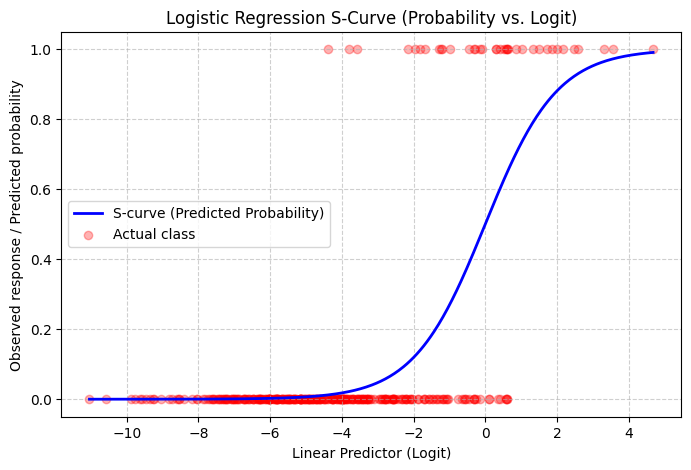

In [15]:
# Create binary column only if it doesn't exist
if 'stress_binary' not in merged_daily_agg.columns:
    merged_daily_agg['stress_binary'] = (merged_daily_agg['avgStressLevel'] > 50).astype(int)


# Logistic regression
model = logistic_reg(
    merged_daily_agg,
    y='stress_binary',
    x=features
)


**Logistic Regression Results:**

The model predicts High Stress days (avgStressLevel > 50) with **92.8% training accuracy**, demonstrating strong classification ability with the available features.

**Key Predictors (based on 335 days of data):**

- **bodyBatteryChange** (negative coefficient): Higher recovery is associated with lower odds of high stress
- **charged** (negative coefficient): Higher charged energy reduces high stress odds
- **restingHeartRate** (negative coefficient): Lower resting heart rate associated with lower stress
- **steps** (small negative coefficient): More activity slightly reduces high stress odds

Note: With fewer features available after data cleaning, the model relies primarily on Body Battery and heart rate metrics rather than granular sleep data.